# Amazon Reviews Analysis

In [1]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1588601591079_0010,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.

In [2]:
from pyspark.sql import functions as F

In [3]:
# Load Data Set
df = spark.read\
          .option("header", "true")\
          .option("inferSchema", "true")\
          .option("basePath", "hdfs:///hive/amazon-reviews-pds/parquet/")\
          .parquet("hdfs:///hive/amazon-reviews-pds/parquet/*")

In [4]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)

In [5]:
df.columns

['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'year', 'product_category']

### Keep only limited number of columns

In [6]:
columns_to_keep = ['customer_id', 'review_id', 'product_id', 'product_parent', 
                   'product_title', 'star_rating', 'helpful_votes', 'total_votes',
                   'verified_purchase', 'review_body', 'review_date', 'year', 'product_category']
df_limited = df.select(columns_to_keep).filter(F.col("year")>2004)

In [7]:
df_limited.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)

## Number of paritions in the DF

In [8]:
df_limited.rdd.getNumPartitions()

216

### Persist DF - will keep as much as possible in the memory after first action/data scan

In [9]:
df_limited.persist()
df_limited.show(5)

+-----------+--------------+----------+--------------+-----------------------+-----------+-------------+-----------+-----------------+----------------------------+-----------+----+----------------+
|customer_id|     review_id|product_id|product_parent|          product_title|star_rating|helpful_votes|total_votes|verified_purchase|                 review_body|review_date|year|product_category|
+-----------+--------------+----------+--------------+-----------------------+-----------+-------------+-----------+-----------------+----------------------------+-----------+----+----------------+
|   16868299|R1UQX4QQ4IU00P|B005I6EU7U|      90774528|   Verso Kindle Fire...|          5|            0|          0|                Y|        I purchased the P...| 2012-06-29|2012|              PC|
|   26929322|R138SH9Y2VTYOB|B00AFY8K7G|     764843002|Ozone Rage ST ゲーミ...|          3|            0|          1|                Y|fpsプレイヤーです<br />足...| 2014-04-09|2014|              PC|
|   42470542|R29LNYEZ

## Perform aggreagtion to get high level Stats

Runtime (abount 5 Gb data scanned): 

    - 3 Slaves on m4.large - abount 4 min
    - 3 Slaves on m4.xlarge - abount 2 min

In [10]:
from pyspark.sql.functions import countDistinct, approx_count_distinct, count, sum, mean, round
df_limited.groupBy("product_category").agg(round(mean("star_rating"),3).alias("Average-star_rating"),
                         round(sum("helpful_votes"),3).alias("Sum-helpful_votes"),
                         round(mean("helpful_votes"),3).alias("Average-helpful_votes"))\
                     .sort("product_category", ascending=False).show(20, False)

+----------------------+-------------------+-----------------+---------------------+
|product_category      |Average-star_rating|Sum-helpful_votes|Average-helpful_votes|
+----------------------+-------------------+-----------------+---------------------+
|Wireless              |3.893              |7934542          |0.879                |
|Video_DVD             |4.336              |16816126         |2.594                |
|PC                    |4.091              |10044848         |1.444                |
|Mobile_Apps           |4.035              |18098912         |2.659                |
|Digital_Video_Download|4.208              |2538073          |0.491                |
|Digital_Ebook_Purchase|4.312              |19141273         |0.998                |
|Books                 |4.364              |53565320         |2.994                |
+----------------------+-------------------+-----------------+---------------------+

In [11]:
df_limited.show(5)

+-----------+--------------+----------+--------------+-----------------------+-----------+-------------+-----------+-----------------+----------------------------+-----------+----+----------------+
|customer_id|     review_id|product_id|product_parent|          product_title|star_rating|helpful_votes|total_votes|verified_purchase|                 review_body|review_date|year|product_category|
+-----------+--------------+----------+--------------+-----------------------+-----------+-------------+-----------+-----------------+----------------------------+-----------+----+----------------+
|   16868299|R1UQX4QQ4IU00P|B005I6EU7U|      90774528|   Verso Kindle Fire...|          5|            0|          0|                Y|        I purchased the P...| 2012-06-29|2012|              PC|
|   26929322|R138SH9Y2VTYOB|B00AFY8K7G|     764843002|Ozone Rage ST ゲーミ...|          3|            0|          1|                Y|fpsプレイヤーです<br />足...| 2014-04-09|2014|              PC|
|   42470542|R29LNYEZ

In [12]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import *
df_rownum = df_limited.withColumn("row_num", row_number()
                      .over(Window.partitionBy("customer_id","product_id","product_category")\
                            .orderBy("review_date"))).select("row_num","customer_id","review_id",\
                                                             "product_id","product_parent","product_title",\
                                                             "star_rating","helpful_votes","total_votes",\
                                                             "verified_purchase","review_body","review_date","year",\
                                                             "product_category")

In [13]:
df_new = df_rownum.select("customer_id","review_id","product_id","product_parent",\
                        "product_title","star_rating","helpful_votes","total_votes",\
                        "verified_purchase","review_body","review_date","year","product_category")\
.where(F.col('row_num')==1)

In [14]:
df_new.persist()

DataFrame[customer_id: string, review_id: string, product_id: string, product_parent: string, product_title: string, star_rating: int, helpful_votes: int, total_votes: int, verified_purchase: string, review_body: string, review_date: date, year: int, product_category: string]

In [15]:
df_new.count()

65911069

## 1. Explore the dataset and provide analysis by product-category and year:

### Number of reviews

In [16]:
df_new.groupBy("product_category","year")\
.agg(F.count('review_id').alias('no_of_reviews'))\
.sort("product_category","year").show(truncate=False)

+----------------------+----+-------------+
|product_category      |year|no_of_reviews|
+----------------------+----+-------------+
|Books                 |2005|521047       |
|Books                 |2006|568401       |
|Books                 |2007|761037       |
|Books                 |2008|827721       |
|Books                 |2009|1015572      |
|Books                 |2010|1120772      |
|Books                 |2011|1303082      |
|Books                 |2012|1649719      |
|Books                 |2013|2965970      |
|Books                 |2014|3540838      |
|Books                 |2015|2860663      |
|Digital_Ebook_Purchase|2005|19           |
|Digital_Ebook_Purchase|2006|36           |
|Digital_Ebook_Purchase|2007|508          |
|Digital_Ebook_Purchase|2008|9607         |
|Digital_Ebook_Purchase|2009|31106        |
|Digital_Ebook_Purchase|2010|102515       |
|Digital_Ebook_Purchase|2011|350138       |
|Digital_Ebook_Purchase|2012|1526599      |
|Digital_Ebook_Purchase|2013|456

### Number of users

In [17]:
df_new.groupBy("product_category","year")\
.agg(F.countDistinct('customer_id').alias('no_of_users'))\
.sort("product_category","year").show(truncate=False)

+----------------------+----+-----------+
|product_category      |year|no_of_users|
+----------------------+----+-----------+
|Books                 |2005|290588     |
|Books                 |2006|317358     |
|Books                 |2007|420721     |
|Books                 |2008|459247     |
|Books                 |2009|574958     |
|Books                 |2010|640507     |
|Books                 |2011|752546     |
|Books                 |2012|951710     |
|Books                 |2013|1620951    |
|Books                 |2014|1859221    |
|Books                 |2015|1548543    |
|Digital_Ebook_Purchase|2005|17         |
|Digital_Ebook_Purchase|2006|33         |
|Digital_Ebook_Purchase|2007|407        |
|Digital_Ebook_Purchase|2008|5829       |
|Digital_Ebook_Purchase|2009|19741      |
|Digital_Ebook_Purchase|2010|61197      |
|Digital_Ebook_Purchase|2011|183970     |
|Digital_Ebook_Purchase|2012|786067     |
|Digital_Ebook_Purchase|2013|1879963    |
+----------------------+----+-----

### Average and Median review stars

In [18]:
df_new.groupBy("product_category","year")\
.agg(F.round(F.mean('star_rating'),3).alias('average_rating'))\
.sort("product_category","year").show(truncate=False)

+----------------------+----+--------------+
|product_category      |year|average_rating|
+----------------------+----+--------------+
|Books                 |2005|4.148         |
|Books                 |2006|4.197         |
|Books                 |2007|4.258         |
|Books                 |2008|4.233         |
|Books                 |2009|4.247         |
|Books                 |2010|4.247         |
|Books                 |2011|4.251         |
|Books                 |2012|4.315         |
|Books                 |2013|4.412         |
|Books                 |2014|4.473         |
|Books                 |2015|4.497         |
|Digital_Ebook_Purchase|2005|3.579         |
|Digital_Ebook_Purchase|2006|4.028         |
|Digital_Ebook_Purchase|2007|3.939         |
|Digital_Ebook_Purchase|2008|3.946         |
|Digital_Ebook_Purchase|2009|3.777         |
|Digital_Ebook_Purchase|2010|3.822         |
|Digital_Ebook_Purchase|2011|4.056         |
|Digital_Ebook_Purchase|2012|4.214         |
|Digital_E

In [19]:
df_new.groupby("product_category","year").agg(F.round(F.expr('percentile(star_rating, array(0.50))')[0]).alias('%50'))\
.sort("product_category","year").show(truncate=False)

+----------------------+----+---+
|product_category      |year|%50|
+----------------------+----+---+
|Books                 |2005|5.0|
|Books                 |2006|5.0|
|Books                 |2007|5.0|
|Books                 |2008|5.0|
|Books                 |2009|5.0|
|Books                 |2010|5.0|
|Books                 |2011|5.0|
|Books                 |2012|5.0|
|Books                 |2013|5.0|
|Books                 |2014|5.0|
|Books                 |2015|5.0|
|Digital_Ebook_Purchase|2005|4.0|
|Digital_Ebook_Purchase|2006|5.0|
|Digital_Ebook_Purchase|2007|5.0|
|Digital_Ebook_Purchase|2008|5.0|
|Digital_Ebook_Purchase|2009|4.0|
|Digital_Ebook_Purchase|2010|4.0|
|Digital_Ebook_Purchase|2011|5.0|
|Digital_Ebook_Purchase|2012|5.0|
|Digital_Ebook_Purchase|2013|5.0|
+----------------------+----+---+
only showing top 20 rows

### Percentiles of length of the review

In [20]:
from pyspark.sql.functions import length
df_length = df_new.withColumn("review_length",length("review_body"))

In [21]:
df_length.groupby("product_category","year").agg(F.round(F.expr('percentile(review_length, array(0.1))')[0]).alias('%1'),\
                                                 F.round(F.expr('percentile(review_length, array(0.25))')[0]).alias('%25'),\
                                                 F.round(F.expr('percentile(review_length, array(0.50))')[0]).alias('%50'),\
                                                 F.round(F.expr('percentile(review_length, array(0.75))')[0]).alias('%75'),\
                                                 F.round(F.expr('percentile(review_length, array(0.9))')[0]).alias('%90'),\
                                                 F.round(F.expr('percentile(review_length, array(0.95))')[0]).alias('%95'))\
.sort("product_category","year").show(truncate=False)

+----------------------+----+-----+-----+------+------+------+------+
|product_category      |year|%1   |%25  |%50   |%75   |%90   |%95   |
+----------------------+----+-----+-----+------+------+------+------+
|Books                 |2005|207.0|367.0|674.0 |1285.0|2290.0|3433.0|
|Books                 |2006|189.0|338.0|628.0 |1221.0|2207.0|3346.0|
|Books                 |2007|144.0|258.0|499.0 |1005.0|1900.0|2946.0|
|Books                 |2008|150.0|267.0|521.0 |1054.0|1970.0|3090.0|
|Books                 |2009|138.0|249.0|505.0 |1058.0|1970.0|3084.0|
|Books                 |2010|140.0|251.0|519.0 |1114.0|2076.0|3267.0|
|Books                 |2011|157.0|259.0|523.0 |1133.0|2130.0|3320.0|
|Books                 |2012|137.0|208.0|432.0 |985.0 |1962.0|3162.0|
|Books                 |2013|117.0|145.0|244.0 |558.0 |1306.0|2102.0|
|Books                 |2014|21.0 |71.0 |161.0 |386.0 |927.0 |1583.0|
|Books                 |2015|12.0 |35.0 |100.0 |307.0 |822.0 |1442.0|
|Digital_Ebook_Purch

### Percentiles for number of reviews per product

In [22]:
df_reviewc = df_new.groupBy("product_title","product_category","year").agg(F.count("review_id").alias('review_count'))
df_reviewc.printSchema()

root
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- review_count: long (nullable = false)

In [23]:
df_reviewc.groupby("product_category","year").agg(F.round(F.expr('percentile(review_count, array(0.1))')[0]).alias('%1'),\
                                                 F.round(F.expr('percentile(review_count, array(0.25))')[0]).alias('%25'),\
                                                 F.round(F.expr('percentile(review_count, array(0.50))')[0]).alias('%50'),\
                                                 F.round(F.expr('percentile(review_count, array(0.75))')[0]).alias('%75'),\
                                                 F.round(F.expr('percentile(review_count, array(0.9))')[0]).alias('%90'),\
                                                 F.round(F.expr('percentile(review_count, array(0.95))')[0]).alias('%95'))\
.sort("product_category","year").show(truncate=False)

+----------------------+----+---+---+---+---+----+----+
|product_category      |year|%1 |%25|%50|%75|%90 |%95 |
+----------------------+----+---+---+---+---+----+----+
|Books                 |2005|1.0|1.0|1.0|2.0|4.0 |7.0 |
|Books                 |2006|1.0|1.0|1.0|2.0|4.0 |7.0 |
|Books                 |2007|1.0|1.0|1.0|2.0|4.0 |7.0 |
|Books                 |2008|1.0|1.0|1.0|2.0|4.0 |7.0 |
|Books                 |2009|1.0|1.0|1.0|2.0|4.0 |7.0 |
|Books                 |2010|1.0|1.0|1.0|2.0|4.0 |8.0 |
|Books                 |2011|1.0|1.0|1.0|2.0|5.0 |8.0 |
|Books                 |2012|1.0|1.0|1.0|2.0|5.0 |8.0 |
|Books                 |2013|1.0|1.0|1.0|3.0|6.0 |10.0|
|Books                 |2014|1.0|1.0|1.0|3.0|6.0 |11.0|
|Books                 |2015|1.0|1.0|1.0|2.0|5.0 |10.0|
|Digital_Ebook_Purchase|2005|1.0|1.0|1.0|1.0|1.0 |1.0 |
|Digital_Ebook_Purchase|2006|1.0|1.0|1.0|1.0|1.0 |1.0 |
|Digital_Ebook_Purchase|2007|1.0|1.0|1.0|1.0|2.0 |2.0 |
|Digital_Ebook_Purchase|2008|1.0|1.0|1.0|1.0|2.0

### Identify week number for each year and product category with most positive reviews (4 and 5 star)

In [24]:
from pyspark.sql.functions import weekofyear
df_new.withColumn('week_of_year',weekofyear("review_date")).filter(F.col("star_rating") >= 4).show(10)

+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+-----------------+--------------------+-----------+----+--------------------+------------+
|customer_id|     review_id|product_id|product_parent|       product_title|star_rating|helpful_votes|total_votes|verified_purchase|         review_body|review_date|year|    product_category|week_of_year|
+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+-----------------+--------------------+-----------+----+--------------------+------------+
|   10000113| RQ9E9A2ISWOQV|B0083XTNJK|     416505290|CrazyOnDigital Re...|          4|            0|          0|                Y|I am very pleased...| 2012-10-02|2012|                  PC|          40|
|   10000185|R1437UFF5891NA|0061986380|     364246210|Extinction Agenda...|          5|            0|          0|                N|Great book. I fin...| 2011-12-29|2011|               

## 2. Provide detailed analysis of "Digital eBook Purchase" versus "Books".

In [25]:
from pyspark.sql.functions import lower,col,trim
df_compare=\
df_new.select("customer_id","review_id","product_id","product_parent",\
               lower(trim(col('product_title'))).alias('product_title'),"star_rating","helpful_votes","total_votes",\
               "verified_purchase","review_body","review_date","year","product_category")\
.where((F.col('product_category')=='Digital_Ebook_Purchase') | (F.col('product_category')=='Books'))

In [26]:
df_month=df_compare.withColumn("month", F.month(df_new["review_date"]))
df_month.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)
 |-- month: integer (nullable = true)

### Pivoted Table

In [27]:
pivoted = df_month.groupBy("year","month").pivot("product_category")\
.agg(count("review_id").alias("review_count"),\
     round(mean("star_rating"),3).alias("avg_rating"))\
.sort("year","month")

pivoted.show(10)

+----+-----+------------------+----------------+-----------------------------------+---------------------------------+
|year|month|Books_review_count|Books_avg_rating|Digital_Ebook_Purchase_review_count|Digital_Ebook_Purchase_avg_rating|
+----+-----+------------------+----------------+-----------------------------------+---------------------------------+
|2005|    1|             40436|           4.121|                                  1|                              5.0|
|2005|    2|             33730|           4.125|                               null|                             null|
|2005|    3|             38882|           4.122|                                  2|                              4.5|
|2005|    4|             36891|           4.132|                                  1|                              5.0|
|2005|    5|             36887|           4.132|                                  1|                              1.0|
|2005|    6|             36600|           4.115|

In [28]:
%%spark -o df_graph

df_graph=\
df_compare.groupBy("year").pivot("product_category")\
.agg(count("review_id").alias("review_count"),\
     round(mean("star_rating"),3).alias("avg_rating"))\
.sort("year")

In [29]:
df_graph.printSchema()

root
 |-- year: integer (nullable = true)
 |-- Books_review_count: long (nullable = true)
 |-- Books_avg_rating: double (nullable = true)
 |-- Digital_Ebook_Purchase_review_count: long (nullable = true)
 |-- Digital_Ebook_Purchase_avg_rating: double (nullable = true)

### Graphs to represent aggregations

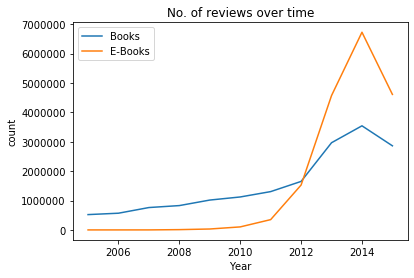

In [30]:
%%local
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(df_graph.year, df_graph.Books_review_count, label = 'Books')
plt.plot(df_graph.year, df_graph.Digital_Ebook_Purchase_review_count, label = 'E-Books')
plt.xlabel('Year')
plt.ylabel('count')
plt.title('No. of reviews over time')
plt.legend()
plt.show()

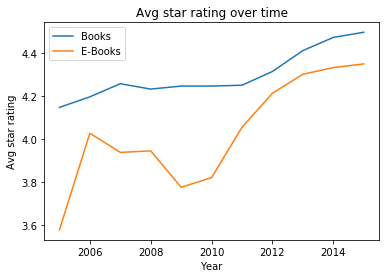

In [31]:
%%local
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(df_graph.year, df_graph.Books_avg_rating, label = 'Books')
plt.plot(df_graph.year, df_graph.Digital_Ebook_Purchase_avg_rating, label = 'E-Books')
plt.xlabel('Year')
plt.ylabel('Avg star rating')
plt.title('Avg star rating over time')
plt.legend()
plt.show()

### Steps to find average ratings of similar products:

In [32]:
df_rating=\
df_compare.groupBy("product_title").pivot("product_category")\
                    .agg(round(mean("star_rating"),3)).alias("avg_rating")\
                    .sort("product_title")

In [33]:
df_rating.printSchema()

root
 |-- product_title: string (nullable = true)
 |-- Books: double (nullable = true)
 |-- Digital_Ebook_Purchase: double (nullable = true)

### Total number of similar products

In [34]:
df_rating.where((F.col("Books").isNotNull()) & (F.col("Digital_Ebook_Purchase").isNotNull())).count()

341282

### Number of similar products which has different ratings in two categories

In [35]:
df_rating.where((F.col("Books").isNotNull()) & (F.col("Digital_Ebook_Purchase").isNotNull())\
               & (F.col("Books") != F.col("Digital_Ebook_Purchase"))).count()

288423

### Comparing the ratings of similar products in both the categories

In [36]:
df_rating.where((F.col("Books").isNotNull()) & (F.col("Digital_Ebook_Purchase").isNotNull())\
               & (F.col("Books") != F.col("Digital_Ebook_Purchase"))).show()

+--------------------+-----+----------------------+
|       product_title|Books|Digital_Ebook_Purchase|
+--------------------+-----+----------------------+
|"...then what?": ...|  5.0|                   2.5|
|"100 people to me...|  4.5|                   5.0|
|"22e ... officer ...|  5.0|                  4.75|
|"a good man is ha...|3.667|                   1.0|
|  "a monster got me"|  5.0|                 4.667|
|"a nice and quiet...|  5.0|                   4.0|
|"a problem from h...|4.111|                 4.333|
|"a survival guide...|  5.0|                   4.0|
|"according to hoy...|  5.0|                   3.4|
|"answer at once":...|4.667|                   5.0|
| "are we there yet?"|  5.0|                 4.333|
|"b" is for betsy ...|4.765|                 4.667|
|"because of the a...|  5.0|                   3.0|
|"blessed harlaxto...| 4.75|                   5.0|
|"blind temptation...|4.154|                 3.667|
|"bloop, bloop!"  ...|4.769|                 4.105|
|"catch 'em 